In [2]:
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow =read_csv('./data/dow.csv')
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
from utils.portfolio_trainer import PortfolioOptimization
df_sp500 = read_csv('./data/sp500.csv')
import warnings
warnings.filterwarnings("ignore")

In [2]:
# columns = reduced_data.columns.tolist()
df =df_dow.copy()
df = df_dow[df_dow.tic.isin( ['AAPL', 'AXP', 'DIS', 'GS', 'MMM', 'WBA'])]

In [3]:
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'
INDICATORS = [
    "close_21_ema",
    "close_62_ema"
    ]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df.query('date>"2013-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")


Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 6


In [4]:
pv = train_data.pivot(columns='tic',values='close')
corr = pv.corr()
data = corr.copy()
high_corr_pairs = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            col_name = corr.columns[i]
            high_corr_pairs.add(col_name)

# Step 3: Drop one of the correlated columns
reduced_data = data.drop(columns=high_corr_pairs)
print("Original columns:", data.columns.tolist())
print("Columns retained after filtering:", reduced_data.columns.tolist())
reduced_data = reduced_data.drop(high_corr_pairs)
reduced_data.style.background_gradient(cmap='coolwarm')

Original columns: ['AAPL', 'AXP', 'DIS', 'GS', 'MMM', 'WBA']
Columns retained after filtering: ['AAPL', 'AXP', 'DIS', 'GS', 'MMM', 'WBA']


In [5]:
def add_volatility(df, periods=21):
    rolling_volatility = df.groupby(
        'tic')['log_return'].rolling(window=periods).std()
    rolling_volatility = rolling_volatility.reset_index(level=0, drop=True)
    # Assign the annualized volatility back to the original DataFrame
    df['volatility'] = rolling_volatility

    # Fill missing values with 0 (first periods will have NaN)
    df['volatility'].fillna(0, inplace=True)

    return df


cleaned_data = add_volatility(cleaned_data)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 6


In [6]:
from utils.mean_variance_optimization import mvo_data
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'
covariances = mvo_data(cleaned_data,[],TEST_START_DATE,TEST_END_DATE)

In [7]:
from pypfopt import EfficientFrontier, objective_functions
list_weights = []
test_data = covariances.query("date > '2021-01-01' & date <'2024-10-01' ")
for i,d in enumerate(test_data.date.unique()):
    ef = EfficientFrontier(test_data[test_data.date == d].iloc[0].returns, test_data[test_data.date == d].iloc[0].cov_list,solver='OSQP')
    ef.min_volatility()
    weights = ef.clean_weights()
    list_weights.append(list(weights.values()))

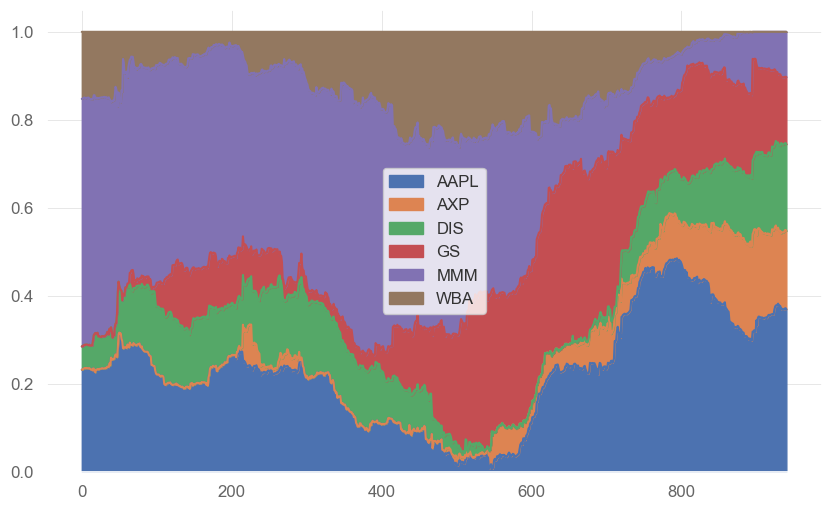

In [10]:
%matplotlib inline
eights = pd.DataFrame(list_weights)
weights.columns =cleaned_data.tic.unique()
weights.plot(kind='area')
plt.show()


In [7]:
res = mvo.mean_variance_optimization(covariances,pct=0.003)

begin_total_asset:50000
end_total_asset:46520.4139881527
Sharpe:  0.07316297627631083
Test Finished!
episode_return 0.9304082797630541


In [8]:
import matplotlib.pyplot as plt
plt.rcdefaults()  
import scienceplots
plt.style.use(['science','ieee'])
def plot_mvo_weights(mvo_result, test_data, include_variance=True, figsize=(11, 8.5),weights_figsize= (4,4), dpi=500, save_path=''):
    w = pd.DataFrame(mvo_result['action'])
    unique_tics = test_data.tic.unique().tolist()
    unique_tics.append('date')
    w['date'] = mvo_result['date']
    w.columns = unique_tics
    fig, ((ax_main, ax_legend), (ax_below, ax_empty)) = plt.subplots(
        nrows=2, ncols=2,
        gridspec_kw={'width_ratios': [10, 1], 'height_ratios': [3, 1]},
        figsize=figsize,
        dpi=dpi
    )

    # Main plot
    w.plot(
        x='date', kind='area', stacked=True,
        colormap="icefire", ax=ax_main, alpha=0.8
    )
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')

    # Legend
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)

    # Variance plot (optional)
    if include_variance:
        ax_below.plot(w['date'], mvo_result['variance'], label='Portfolio Variance')
        ax_below.set_xlim(w.date.min(), w.date.max())
        ax_below.set_ylabel('Variance')
        ax_below.tick_params(axis='x', rotation=30)
    else:
        fig.delaxes(ax_below)

    # Remove empty subplot
    fig.delaxes(ax_empty)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=500)
    plt.show()
    # Save or show




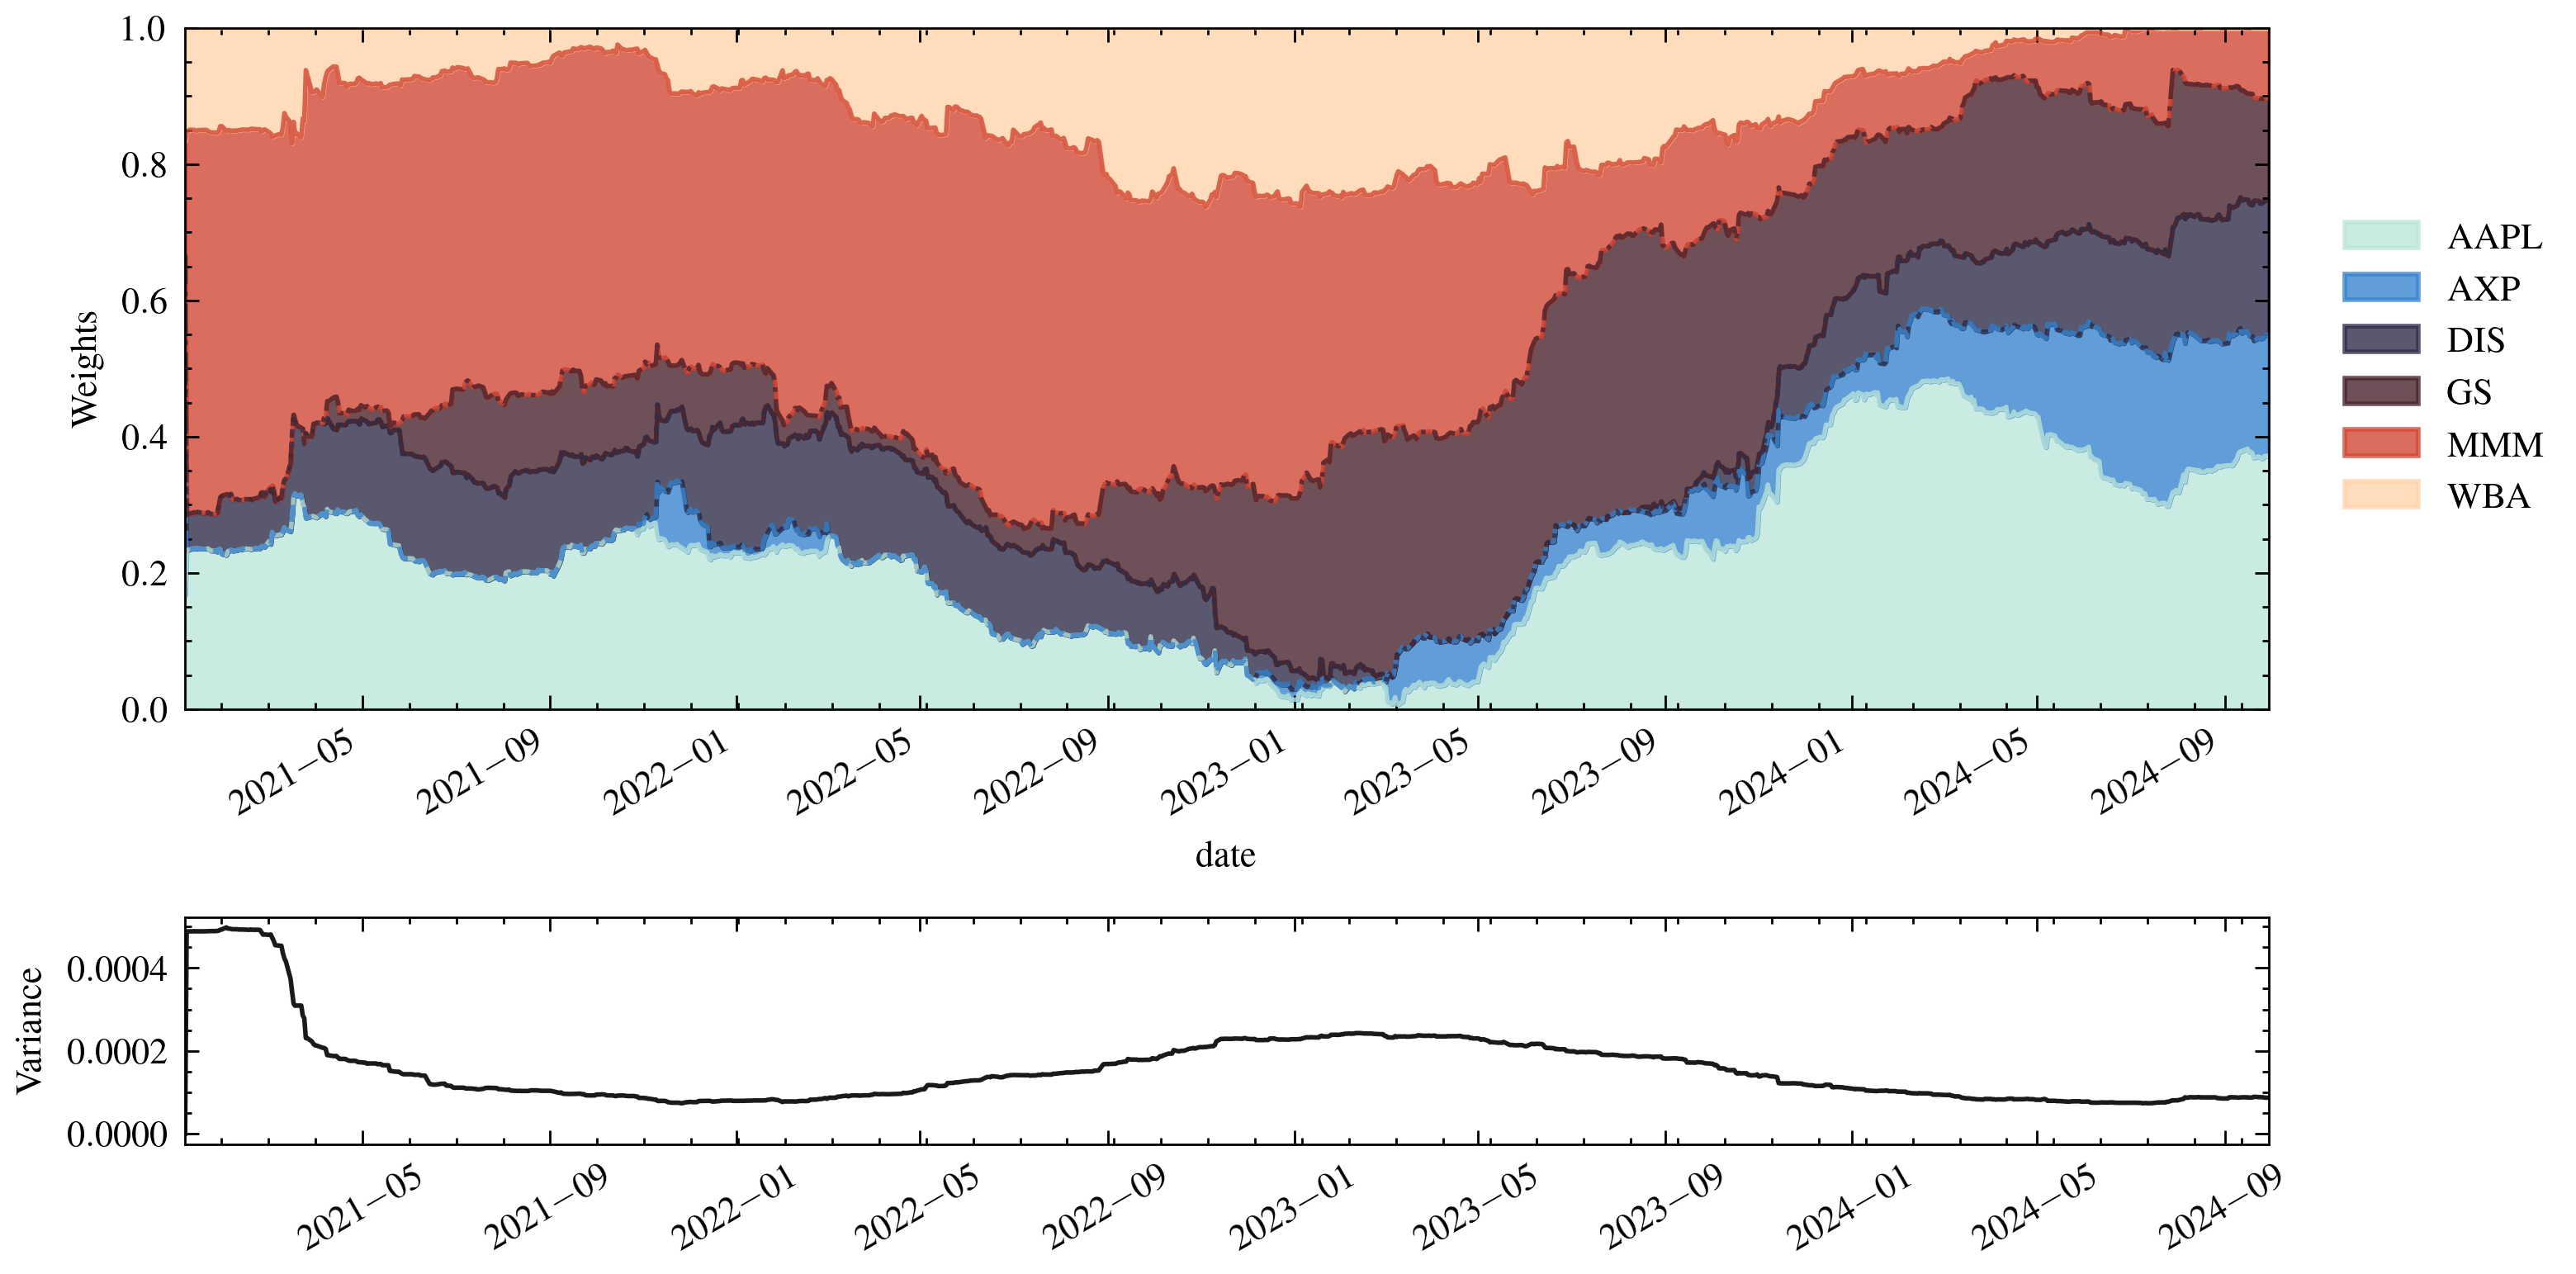

In [56]:
%matplotlib inline
plot_mvo_weights(res,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_detail.png')

In [ ]:
res = mvo.mean_variance_optimization(covariances,pct=0.003,objective='sharpe',rf=0)

PPO WITHOUT WEIGHT

ppo_690000_steps
ppo_close_log_return_volatility_window_size_5_0.003_proximal_policy_optimization_simple_return

Successfully load model data\ppo_close_log_return_volatility_window_size_5_0.003_proximal_policy_optimization_simple_return\ppo_140000_steps
Initial portfolio value:250000
Final portfolio value: 323716.9375
Final accumulative portfolio value: 1.29486775
Maximum DrawDown: -0.2859202822893331
Sharpe ratio: 0.48029368299319664
hit end!


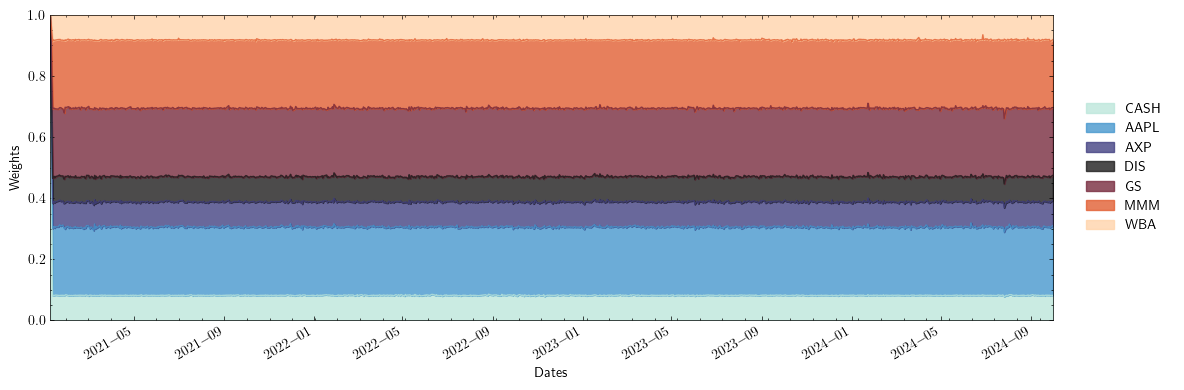

In [11]:
from utils.plotting_helpers import plot_weights

%matplotlib inline

optimizer = PortfolioOptimization(
    transaction_fee=0.003,comission_fee_model='trf', vectorize=False, tag="proximal_policy_optimization_simple_return", sharp_reward=False, last_weight=False, add_cash=True)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","volatility"],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 128},
#                         window_size=5,
#                         iterations=1000_000)>
model = optimizer.load_from_file(
    'ppo', path="data\ppo_close_log_return_volatility_window_size_5_0.003_proximal_policy_optimization_simple_return\ppo_140000_steps")
test_result = optimizer.DRL_prediction(model, test_data, ["close", "log_return","volatility"])
from utils.plotting_helpers import plot_weights
plot_weights(test_result[0].weights, test_result[0].date, test_result[1])


Struggles with rew

In [ ]:
import torch

a2coptimizer = PortfolioOptimization(
    transaction_fee=0.003, vectorize=False,comission_fee_model='trf', tag="a2c_simple_return", sharp_reward=False, last_weight=False, add_cash=True)
# a2coptimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","volatility"],
#                         model_name="a2c",
#                         args={"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0005},
#                         window_size=5,
#                         iterations=1000_000)
model = a2coptimizer.load_from_file(
    'ppo', path="data\sac_close_log_return_volatility_window_size_5_0.003_a2c_simple_return\ppo_140000_steps")
test_result_sac = optimizer.DRL_prediction(model, test_data, ["close", "log_return","volatility"])
from utils.plotting_helpers import plot_weights
plot_weights(test_result[0].weights, test_result[0].date, test_result[1])


Successfully load model data\sac_close_log_return_volatility_window_size_5_0.003_a2c_simple_return\sac_80000_steps
Initial portfolio value:250000
Final portfolio value: 286137.4375
Final accumulative portfolio value: 1.14454975
Maximum DrawDown: -0.30601674109544375
Sharpe ratio: 0.2946413491177311
hit end!


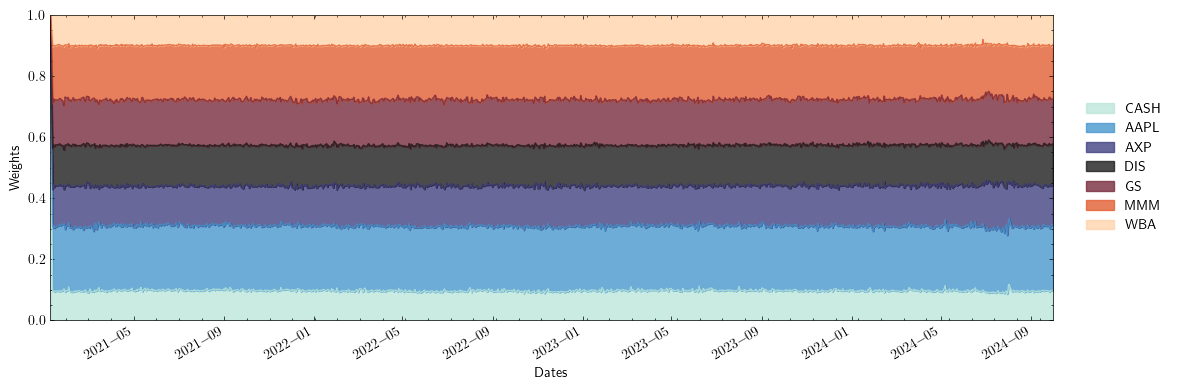

In [29]:
import torch

sac_coptimizer = PortfolioOptimization(
    transaction_fee=0.003, vectorize=False,comission_fee_model='trf', tag="a2c_simple_return", sharp_reward=False, last_weight=False, add_cash=True)
# a2coptimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","volatility"],
#                         model_name="sac",
#                         window_size=5,
#                         iterations=1000_000)
model_sac = sac_coptimizer.load_from_file(
    'sac', path="data\sac_close_log_return_volatility_window_size_5_0.003_a2c_simple_return\sac_80000_steps")
test_result_sac = sac_coptimizer.DRL_prediction(model_sac, test_data, ["close", "log_return","volatility"])
from utils.plotting_helpers import plot_weights
plot_weights(test_result_sac[0].weights, test_result_sac[0].date, test_result_sac[1])

In [ ]:
from utils.plotting_helpers import plot_weights

def linear_schedule(initial_value):
    """
    Linear learning rate schedule.
    :param initial_value: (float) Initial learning rate.
    :return: (function) A function that computes the learning rate given remaining progress.
    """
    def schedule(progress_remaining):
        """
        Progress remaining is a value between 1 (start of training) and 0 (end of training).
        """
        return progress_remaining * initial_value
    return schedule

optimizer = PortfolioOptimization(
    transaction_fee=0.003,comission_fee_model='trf', vectorize=False, tag="proximal_policy_optimization_sharpe", sharp_reward=True, last_weight=False, add_cash=True)
optimizer.train_model(train_data,
                        validation_data,
                        features=["close", "log_return","volatility"],
                        model_name="ppo",
                        args={"n_steps":  256, "batch_size": 64,"learning_rate":linear_schedule(0.0003)},
                        window_size=5,
                        iterations=1000_000)
# model = optimizer.load_from_file(
#     'ppo', path="data\ppo_close_log_return_volatility_window_size_5_0.003_proximal_policy_optimization_simple_return\ppo_140000_steps")
# test_result = optimizer.DRL_prediction(model, test_data, ["close", "log_return","volatility"])
# from utils.plotting_helpers import plot_weights
# plot_weights(test_result[0].weights, test_result[0].date, test_result[1])


Compare

In [34]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique()) + 1
environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0.003,
    time_window=5,
    features = ["close","return"],
    normalize_df=None,
    add_cash=True
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1087188.875
Final accumulative portfolio value: 1.087188875
Maximum DrawDown: -0.29962474816603357
Sharpe ratio: 0.21739403684231506


# Compare DOW

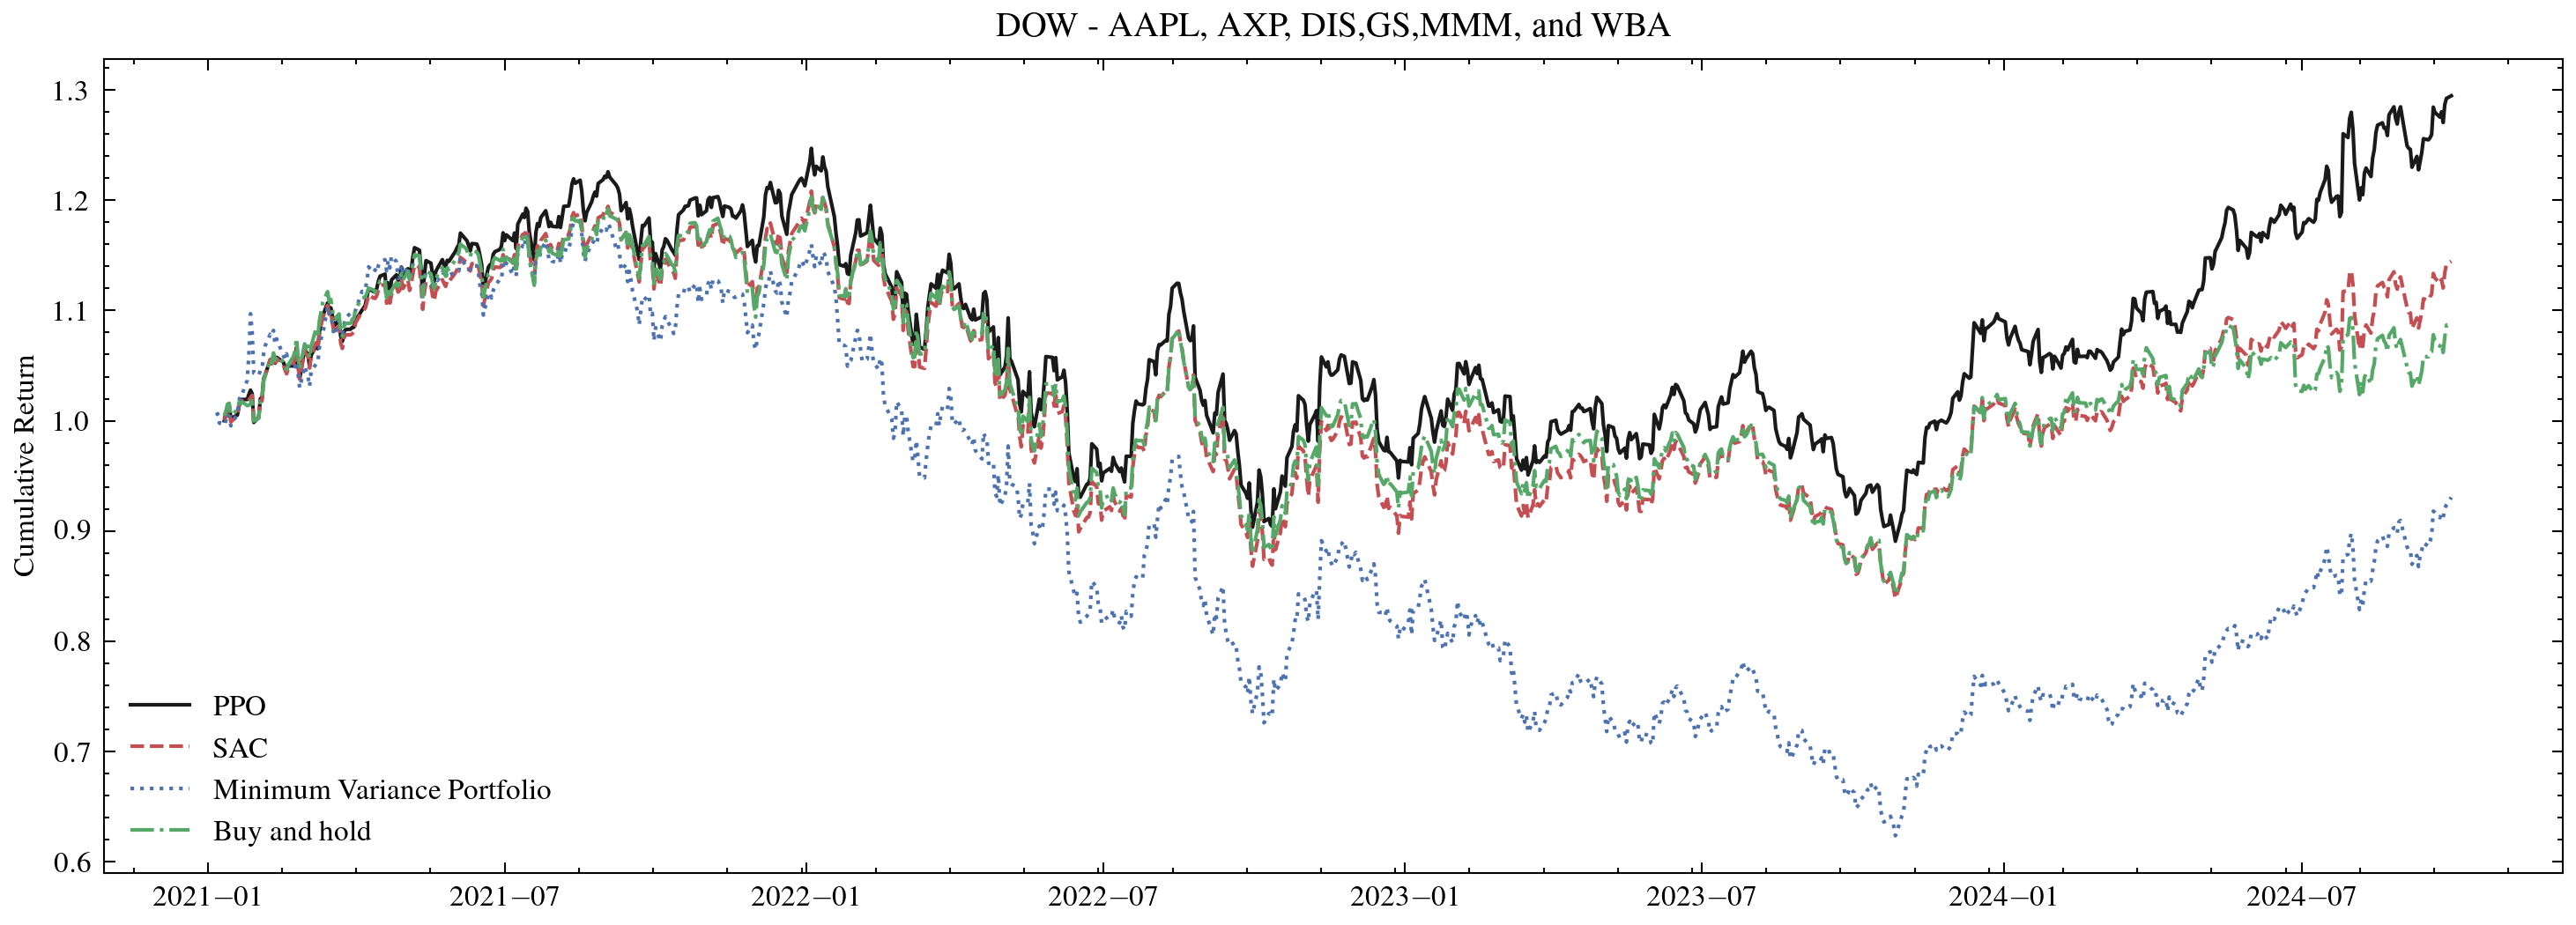

In [35]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
%matplotlib inline
plt.figure(figsize=(12,4),dpi=300)
plt.plot(test_result[0].get('date'),(test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
plt.plot(test_result_sac[0].get('date'),(test_result_sac[0]['account'].pct_change() + 1).cumprod(),label='SAC')
plt.plot(res['test'].date,(res['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
plt.plot(environment_train_buy_and_hold._date_memory,(pd.Series(environment_train_buy_and_hold._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
plt.legend()
plt.ylabel('Cumulative Return')
plt.title('DOW - AAPL, AXP, DIS,GS,MMM, and WBA')
plt.savefig('dow_comparison.png', dpi=500)
plt.show()

SP 500

In [3]:
df_sp500 = read_csv('./data/sp500.csv')
df = df_sp500[df_sp500.tic.isin(
    ['PG', 'BA', 'NKE', 'JPM', 'MCD', 'TRV', 'UNH', 'SHW', 'VZ'])]

In [4]:
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'
INDICATORS = [
    "close_21_ema",
    "close_62_ema"
    ]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df.query('date>"2013-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")


Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 9


In [99]:
import data_processor

train_data,test_data,validation_data = data_processor.get_data(df)

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 9


In [107]:
import matplotlib.pyplot as plt
plt.rcdefaults()  
import scienceplots
plt.style.use(['science','ieee'])
def plot_lines(ptivot_table,figsize=(8, 4), dpi=500, save_path=''):

    fig, ((ax_main, ax_legend)) = plt.subplots(
        nrows=1, ncols=2,
        gridspec_kw={'width_ratios': [10, 1]},
        figsize=figsize,
        dpi=dpi
    )

    # Main plot
    ptivot_table.plot(
        colormap="icefire", ax=ax_main
    )
    ax_main.set_ylabel('returns')

    # Legend
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=500)
    plt.show()
    # Save or show


In [105]:
returns = train_data.pivot_table(index='date',values='log_return',columns='tic')
stds = train_data.pivot_table(index='date',values='volatility',columns='tic')

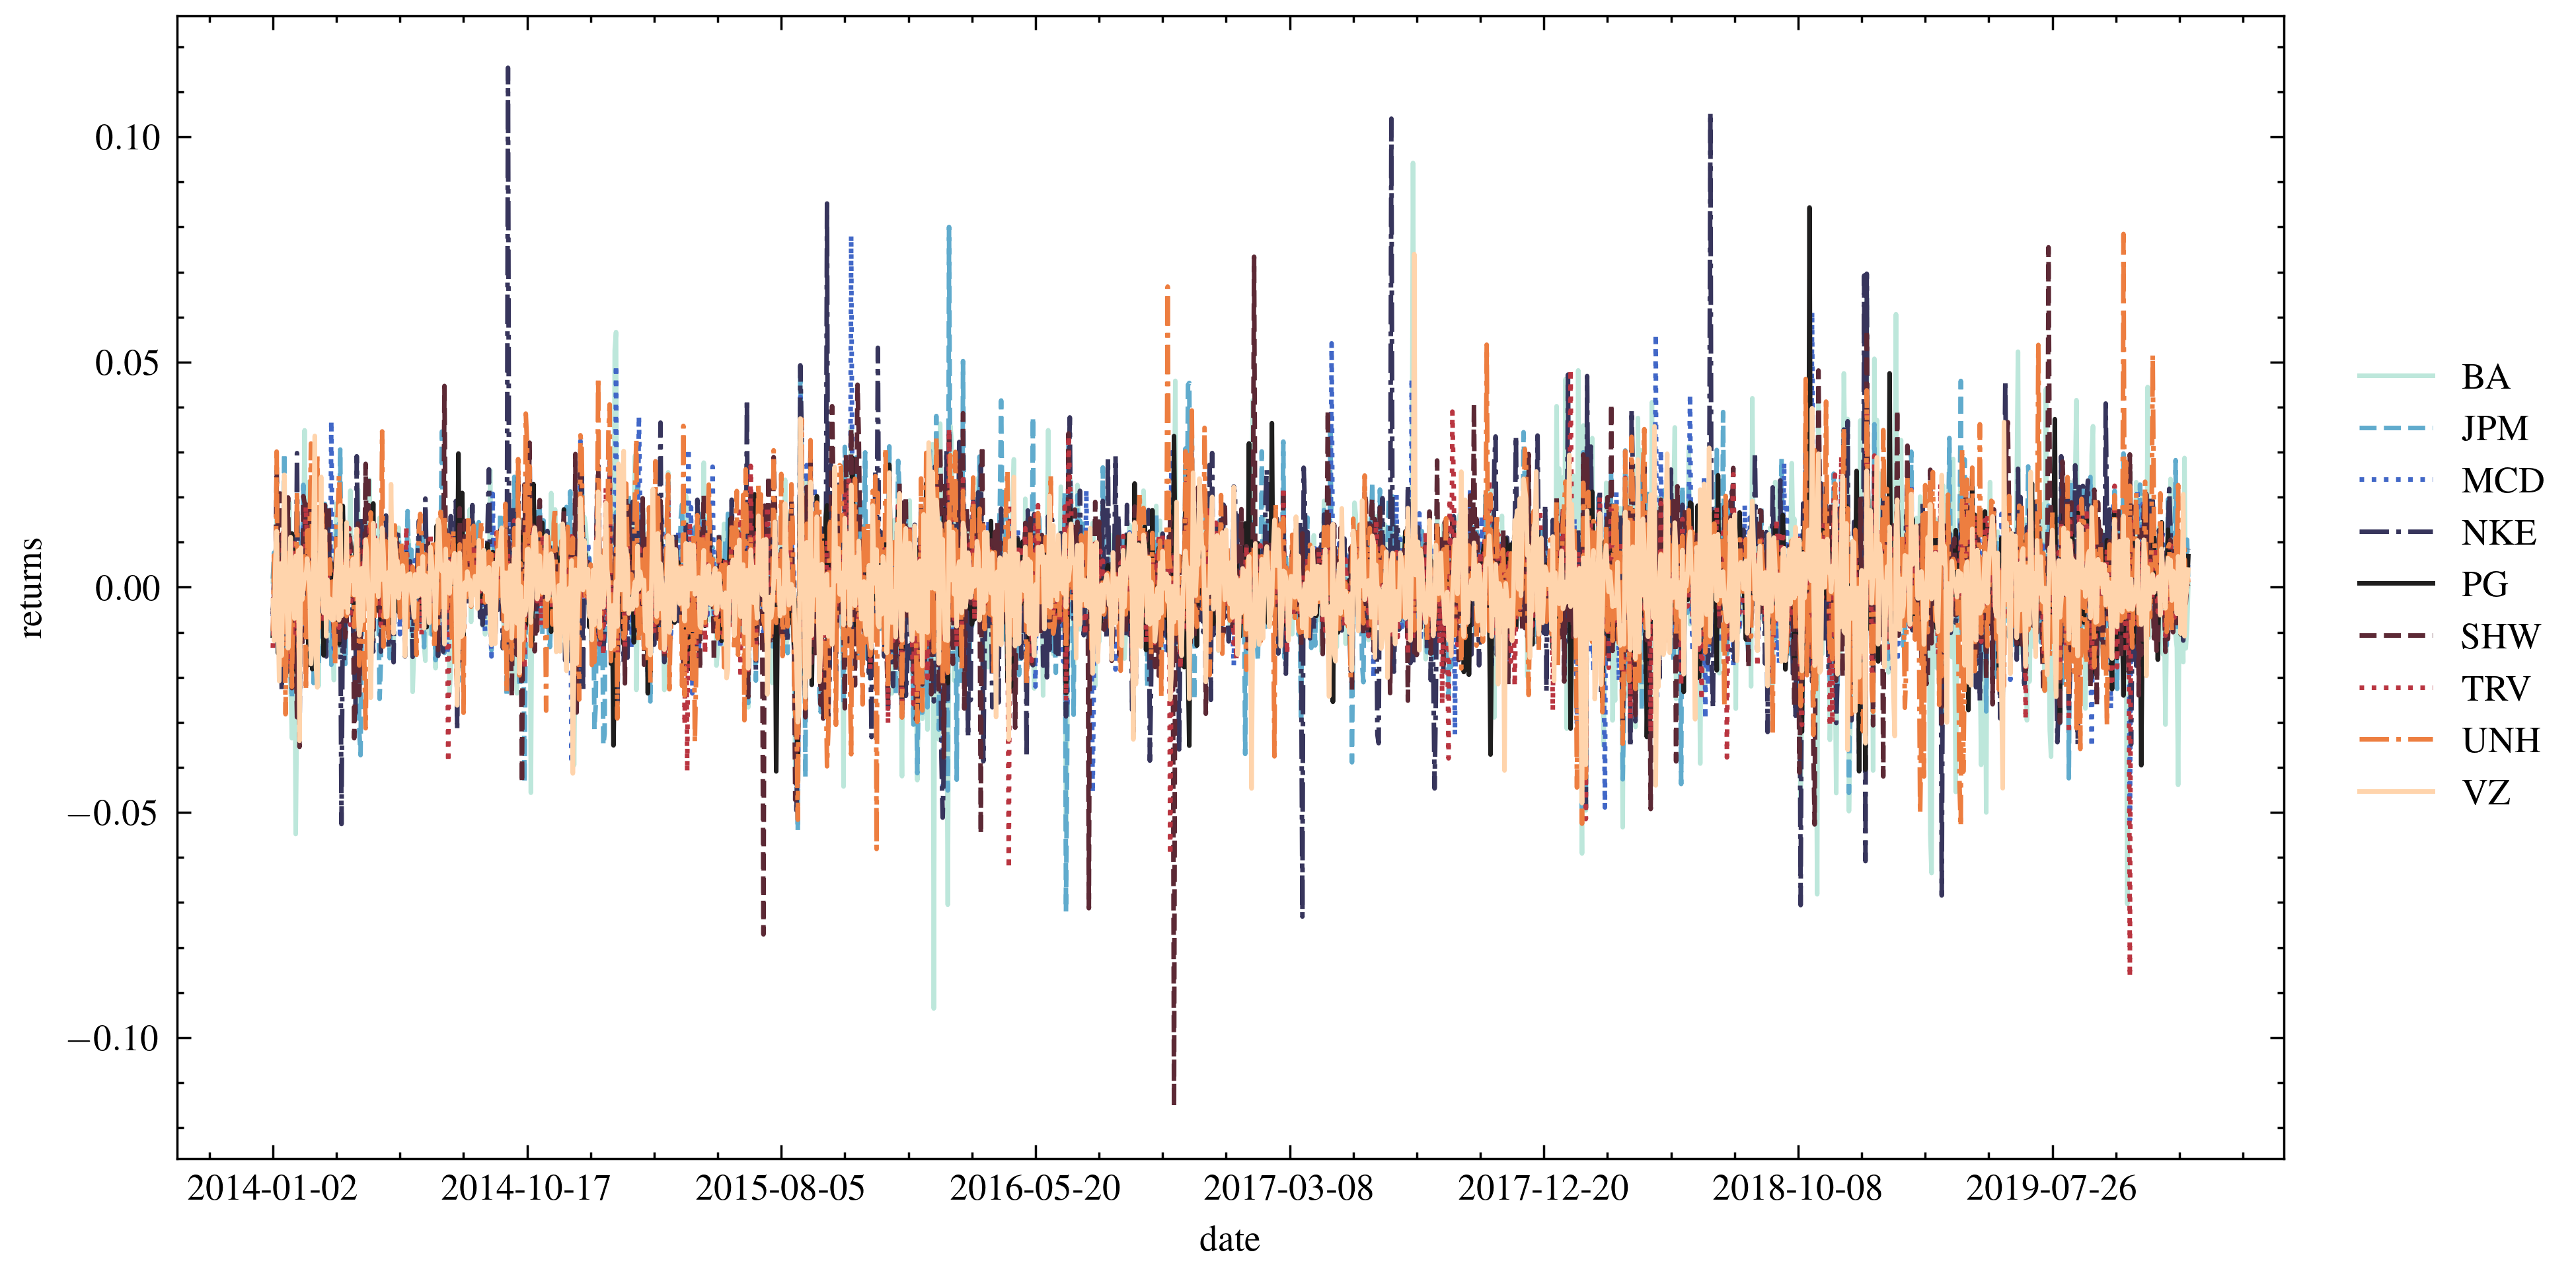

In [108]:
plot_lines(returns)

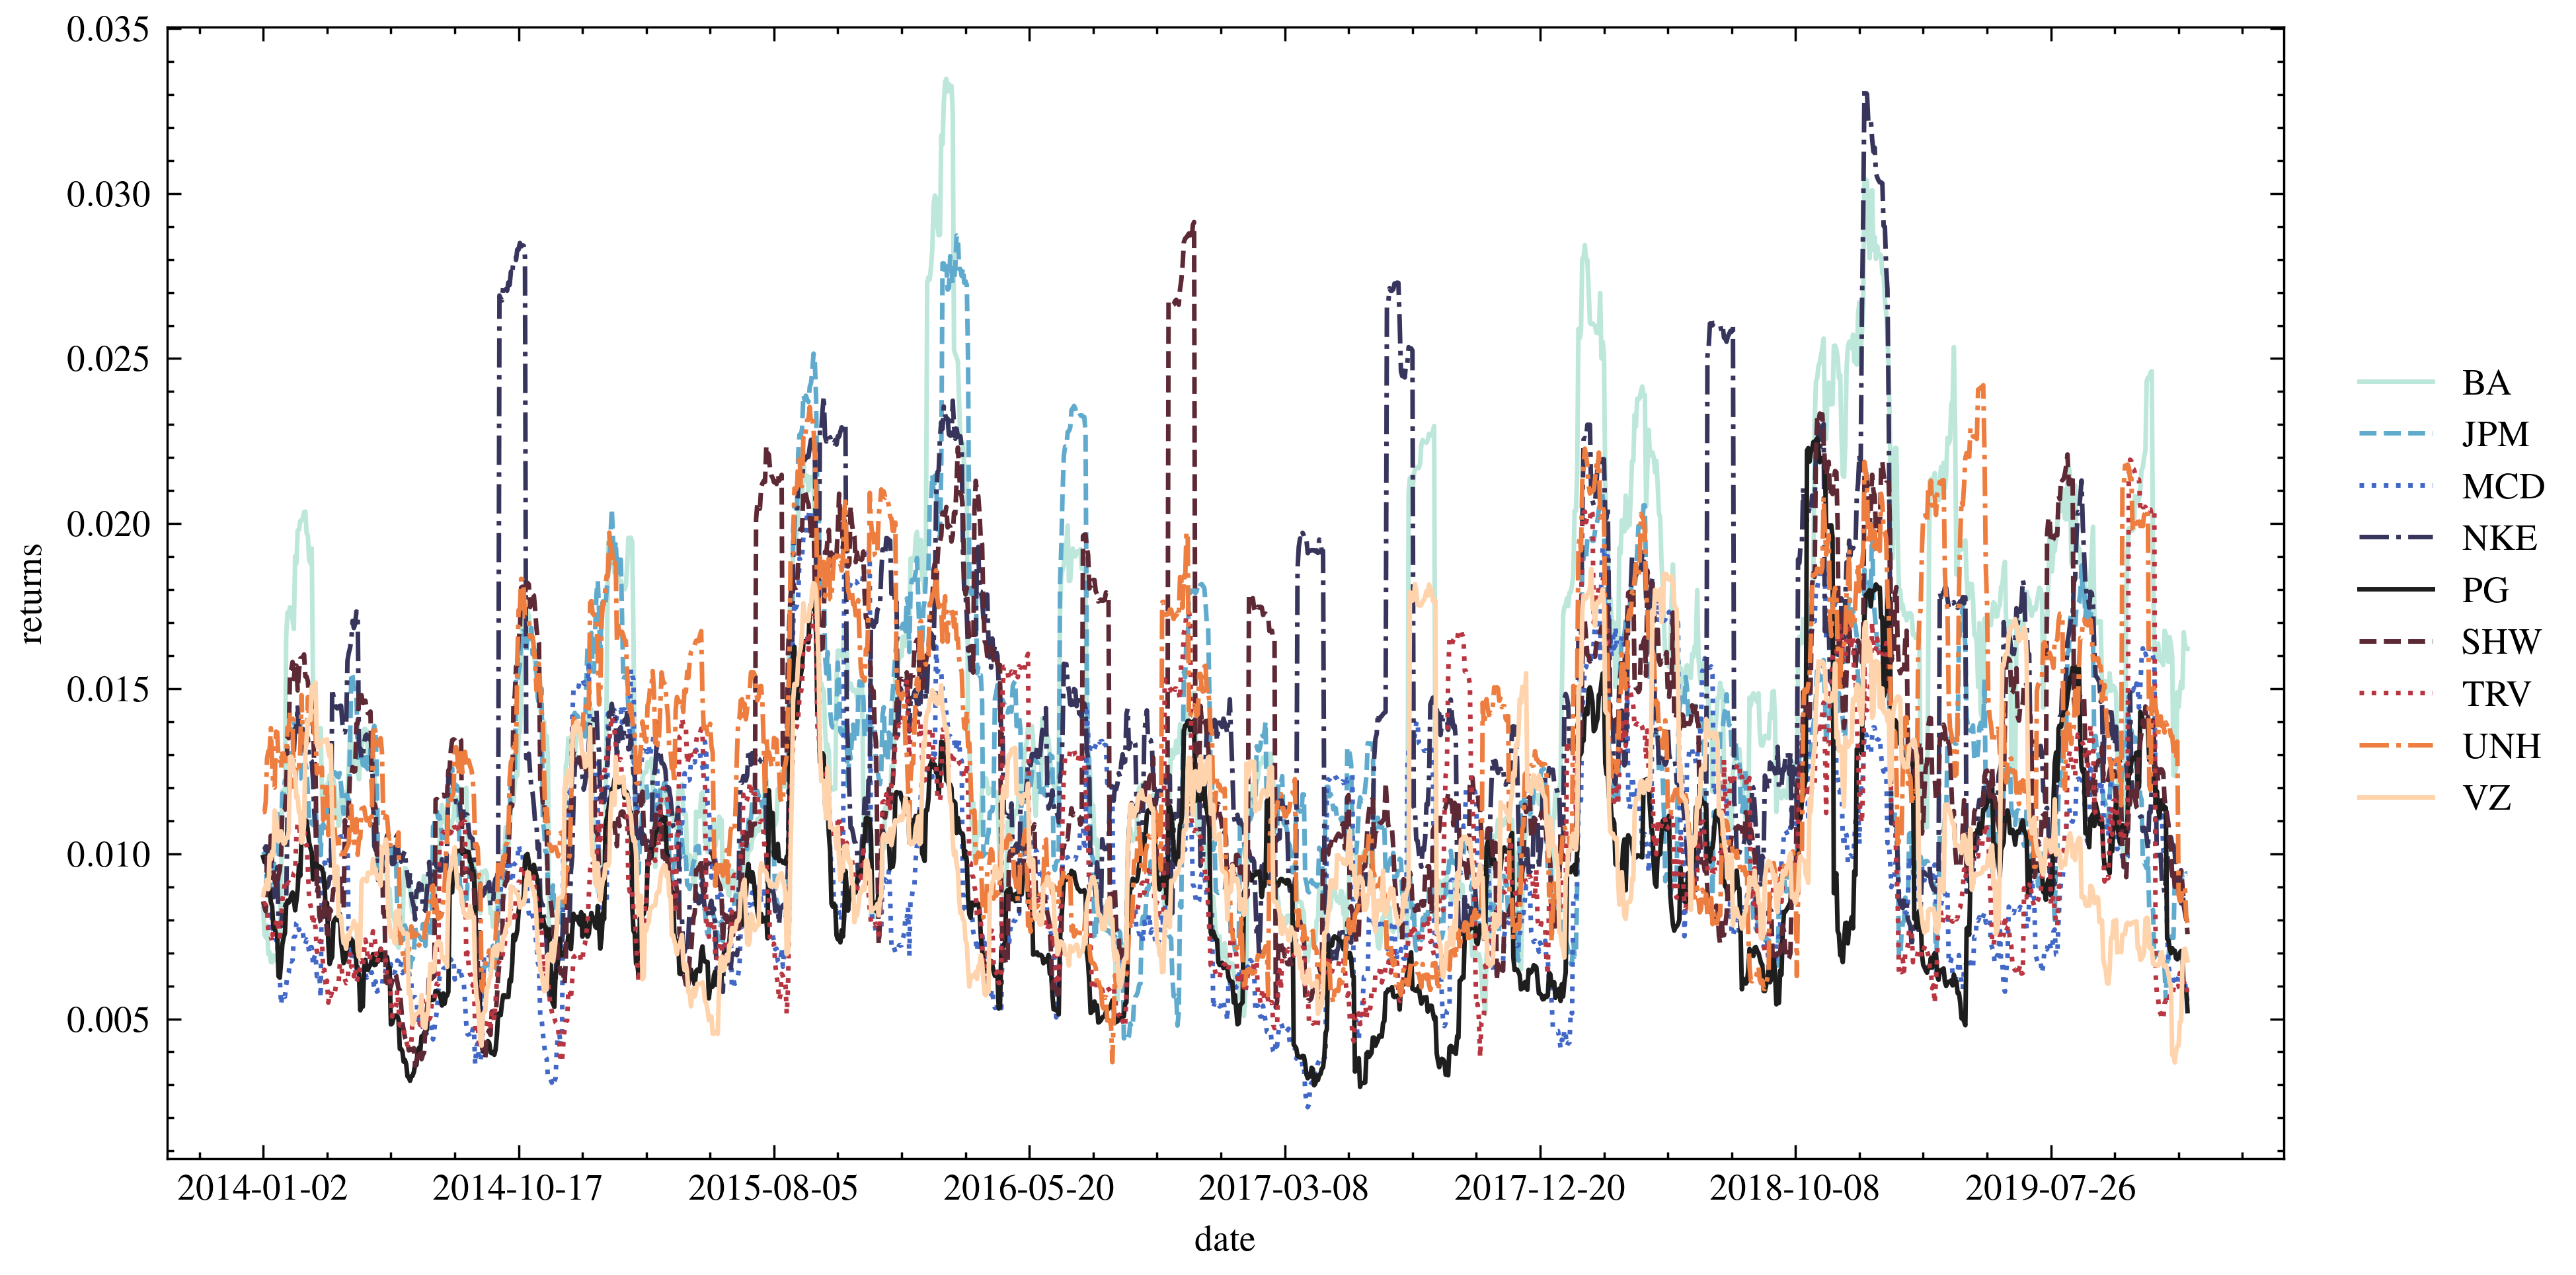

In [109]:
plot_lines(stds)

ppo_close_log_return_volatility_window_size_5_0.003_proximal_policy_optimization_simple_return_sp500
ppo_180000_steps

In [12]:
def add_volatility(df, periods=21):
    rolling_volatility = df.groupby(
        'tic')['log_return'].rolling(window=periods).std()
    rolling_volatility = rolling_volatility.reset_index(level=0, drop=True)
    # Assign the annualized volatility back to the original DataFrame
    df['volatility'] = rolling_volatility

    # Fill missing values with 0 (first periods will have NaN)
    df['volatility'].fillna(0, inplace=True)

    return df


cleaned_data = add_volatility(cleaned_data)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 9


Successfully load model data\ppo_close_log_return_volatility_window_size_5_0.003_proximal_policy_optimization_simple_return_sp500\ppo_170000_steps
Initial portfolio value:250000
Final portfolio value: 295846.65625
Final accumulative portfolio value: 1.183386625
Maximum DrawDown: -0.2594055862126785
Sharpe ratio: 0.387297169036576
hit end!


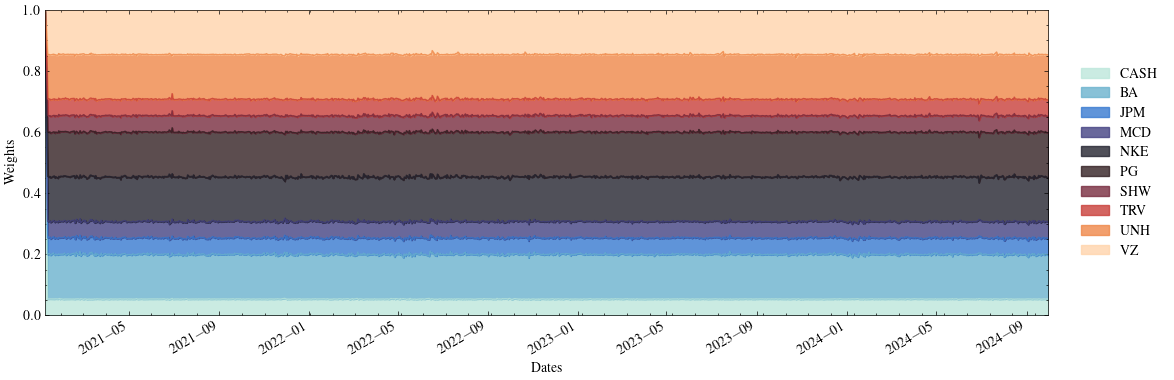

In [26]:
optimizer_sp500 = PortfolioOptimization(
    transaction_fee=0.003,comission_fee_model='trf', vectorize=False, tag="proximal_policy_optimization_simple_return_sp500", sharp_reward=False, last_weight=False, add_cash=True)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","volatility"],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 128},
#                         policy_kwargs={'net_arch': [{'pi': [128, 128], 'vf': [128, 128]}]},
#                         window_size=5,
#                         iterations=1000_000)
model = optimizer_sp500.load_from_file(
    'ppo', path="data\ppo_close_log_return_volatility_window_size_5_0.003_proximal_policy_optimization_simple_return_sp500\ppo_170000_steps")
test_result_sp500 = optimizer_sp500.DRL_prediction(model, test_data, ["close", "log_return","volatility"])
from utils.plotting_helpers import plot_weights
plot_weights(test_result_sp500[0].weights, test_result_sp500[0].date, test_result_sp500[1])

In [5]:
from utils.mean_variance_optimization import mvo_data
covariances = mvo_data(cleaned_data,[],TEST_START_DATE,TEST_END_DATE)

In [29]:
result_sp500 = mvo.mean_variance_optimization(covariances,pct=0)

begin_total_asset:50000
end_total_asset:59011.4879633126
Sharpe:  0.4028323421160539
Test Finished!
episode_return 1.1802297592662518


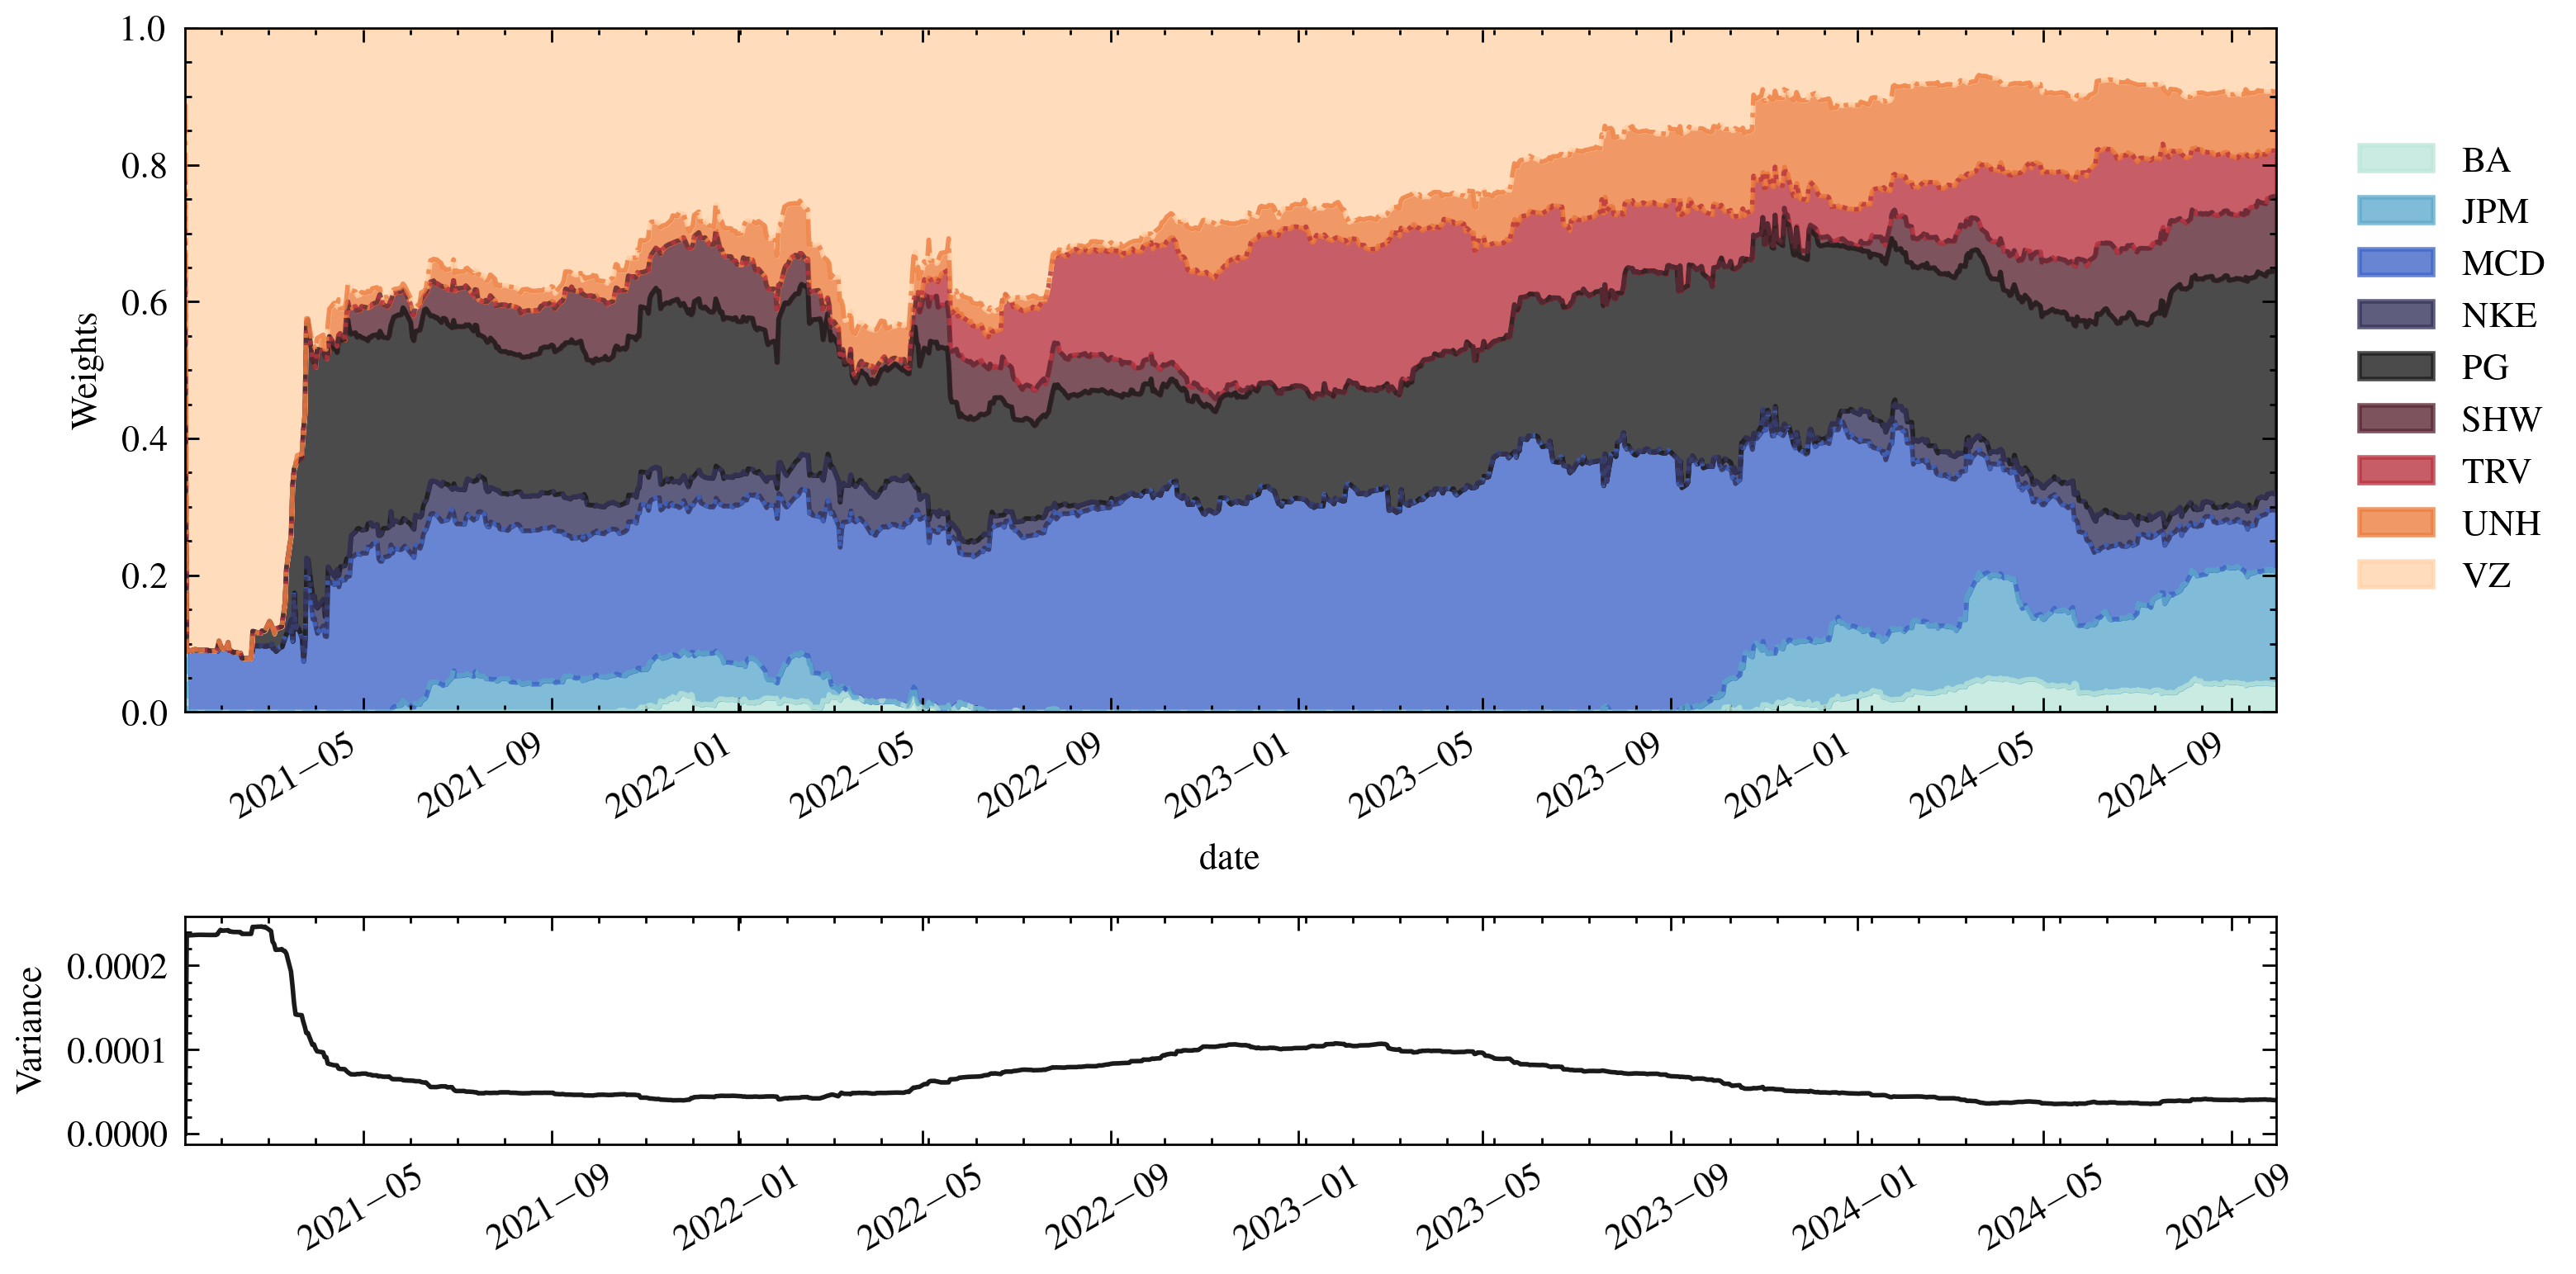

In [9]:
%matplotlib inline
plot_mvo_weights(result_sp500,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_detail_sp500.png')

In [10]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique()) + 1
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0.003,
    time_window=5,
    features = ["close","return"],
    normalize_df=None,
    add_cash=True
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1292988.25
Final accumulative portfolio value: 1.29298825
Maximum DrawDown: -0.23695940702927576
Sharpe ratio: 0.5896216245126724


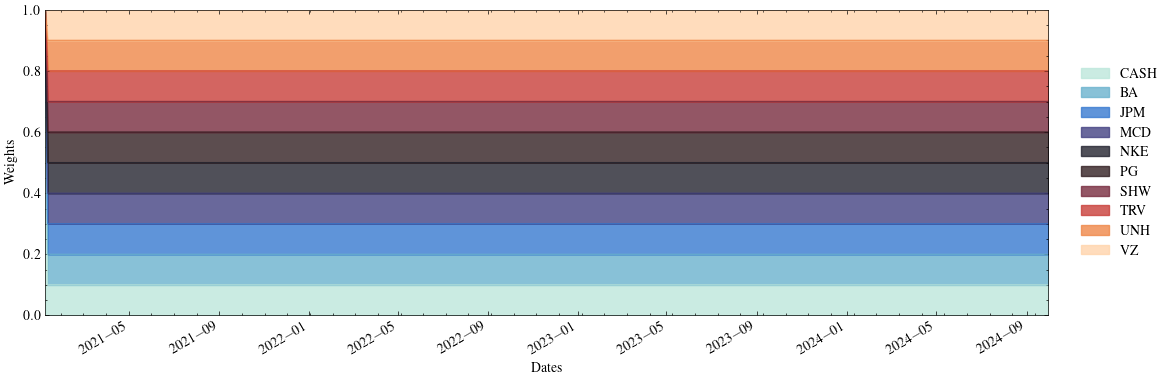

In [23]:
plot_weights(np.array(environment_train_buy_and_hold_sp500._actions_memory),environment_train_buy_and_hold_sp500._date_memory, test_data.tic.unique().tolist())

# Compare SP500

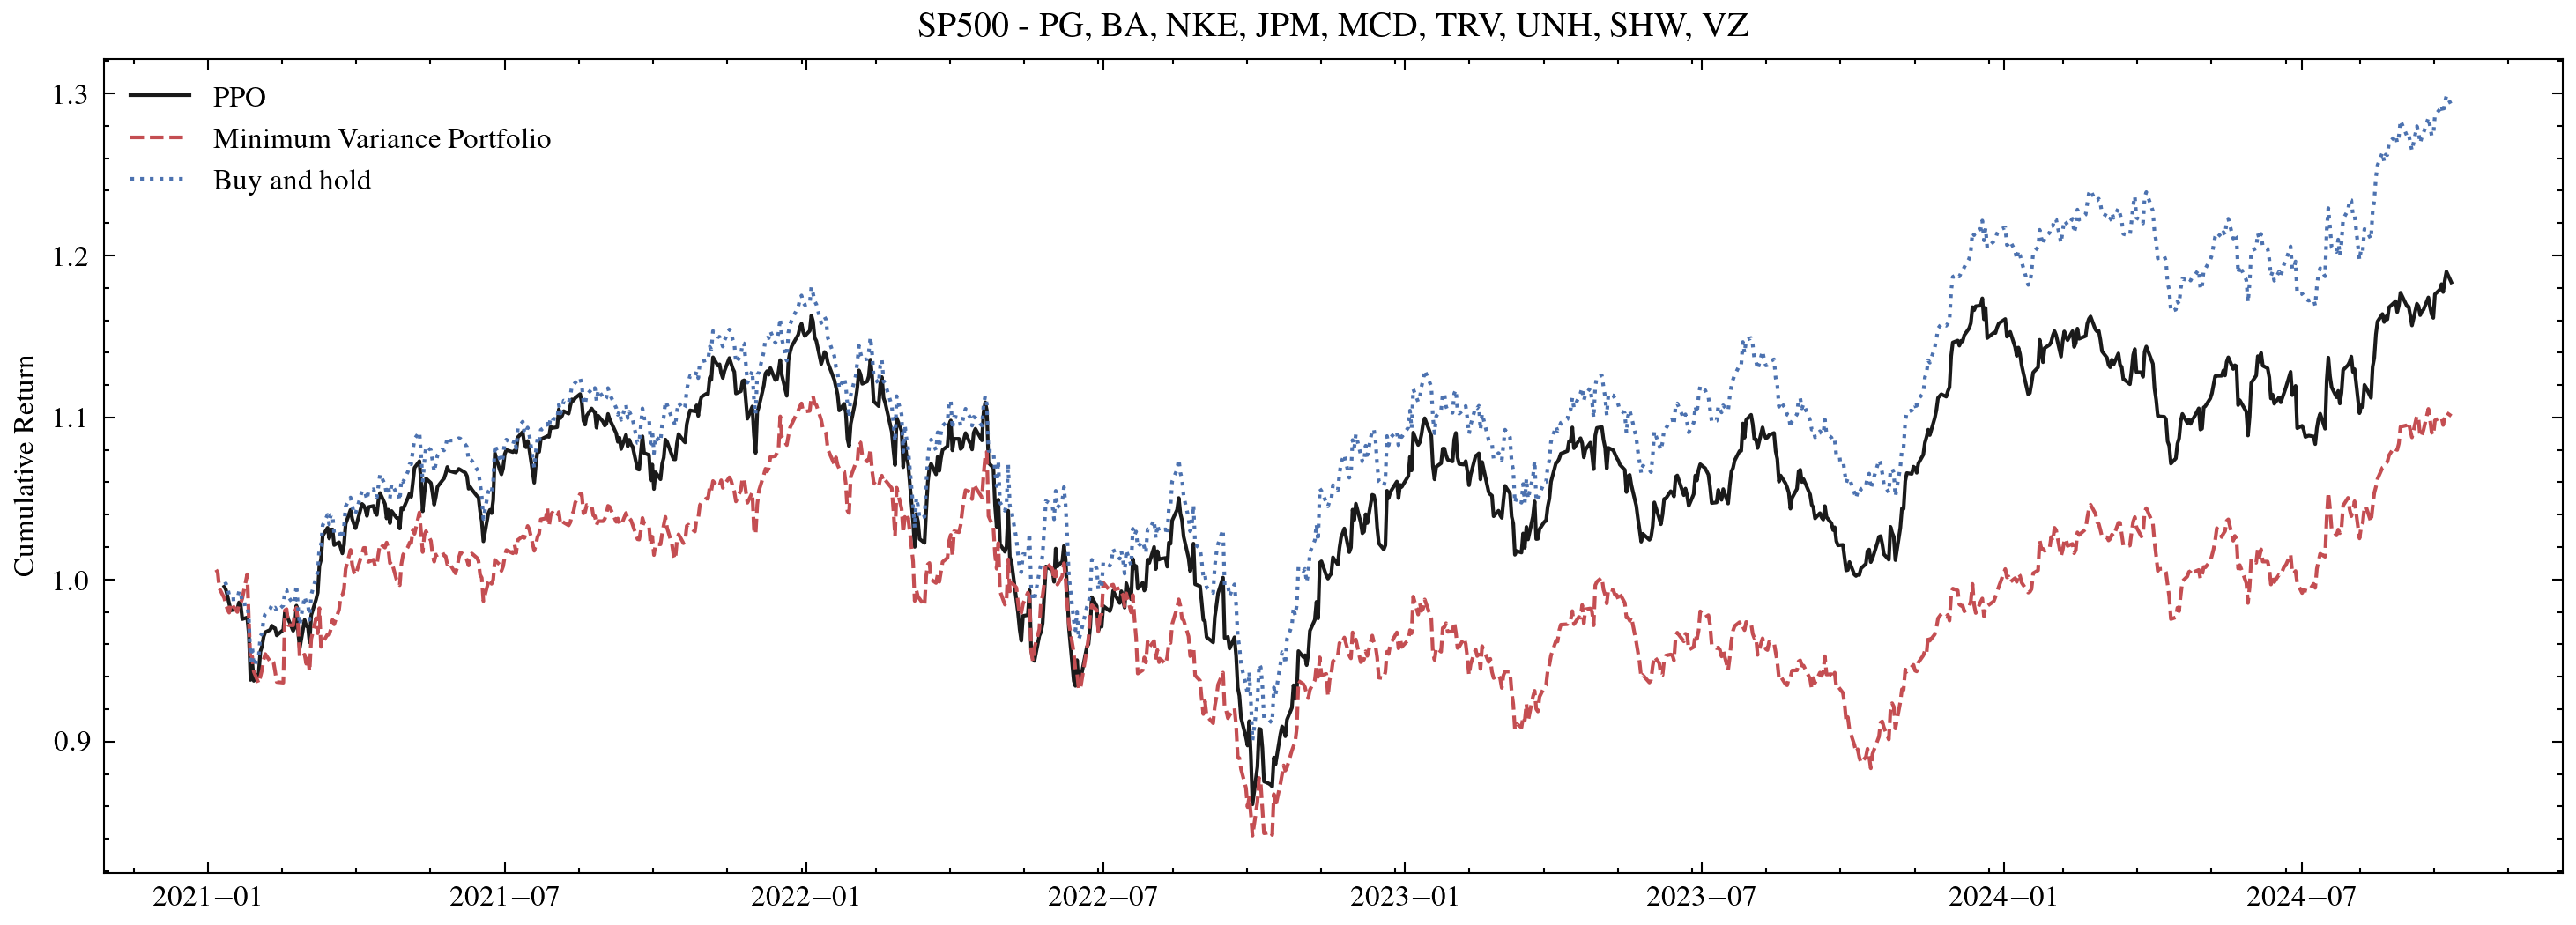

In [28]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
%matplotlib inline
plt.figure(figsize=(12,4),dpi=300)
plt.plot(test_result_sp500[0].get('date'),(test_result_sp500[0]['account'].pct_change() +1).cumprod(),label='PPO')
plt.plot(result_sp500['test'].date,(result_sp500['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
plt.legend()
plt.ylabel('Cumulative Return')
plt.title('SP500 - PG, BA, NKE, JPM, MCD, TRV, UNH, SHW, VZ')
plt.savefig('dow_comparison.png', dpi=500)
plt.show()

# No fee  

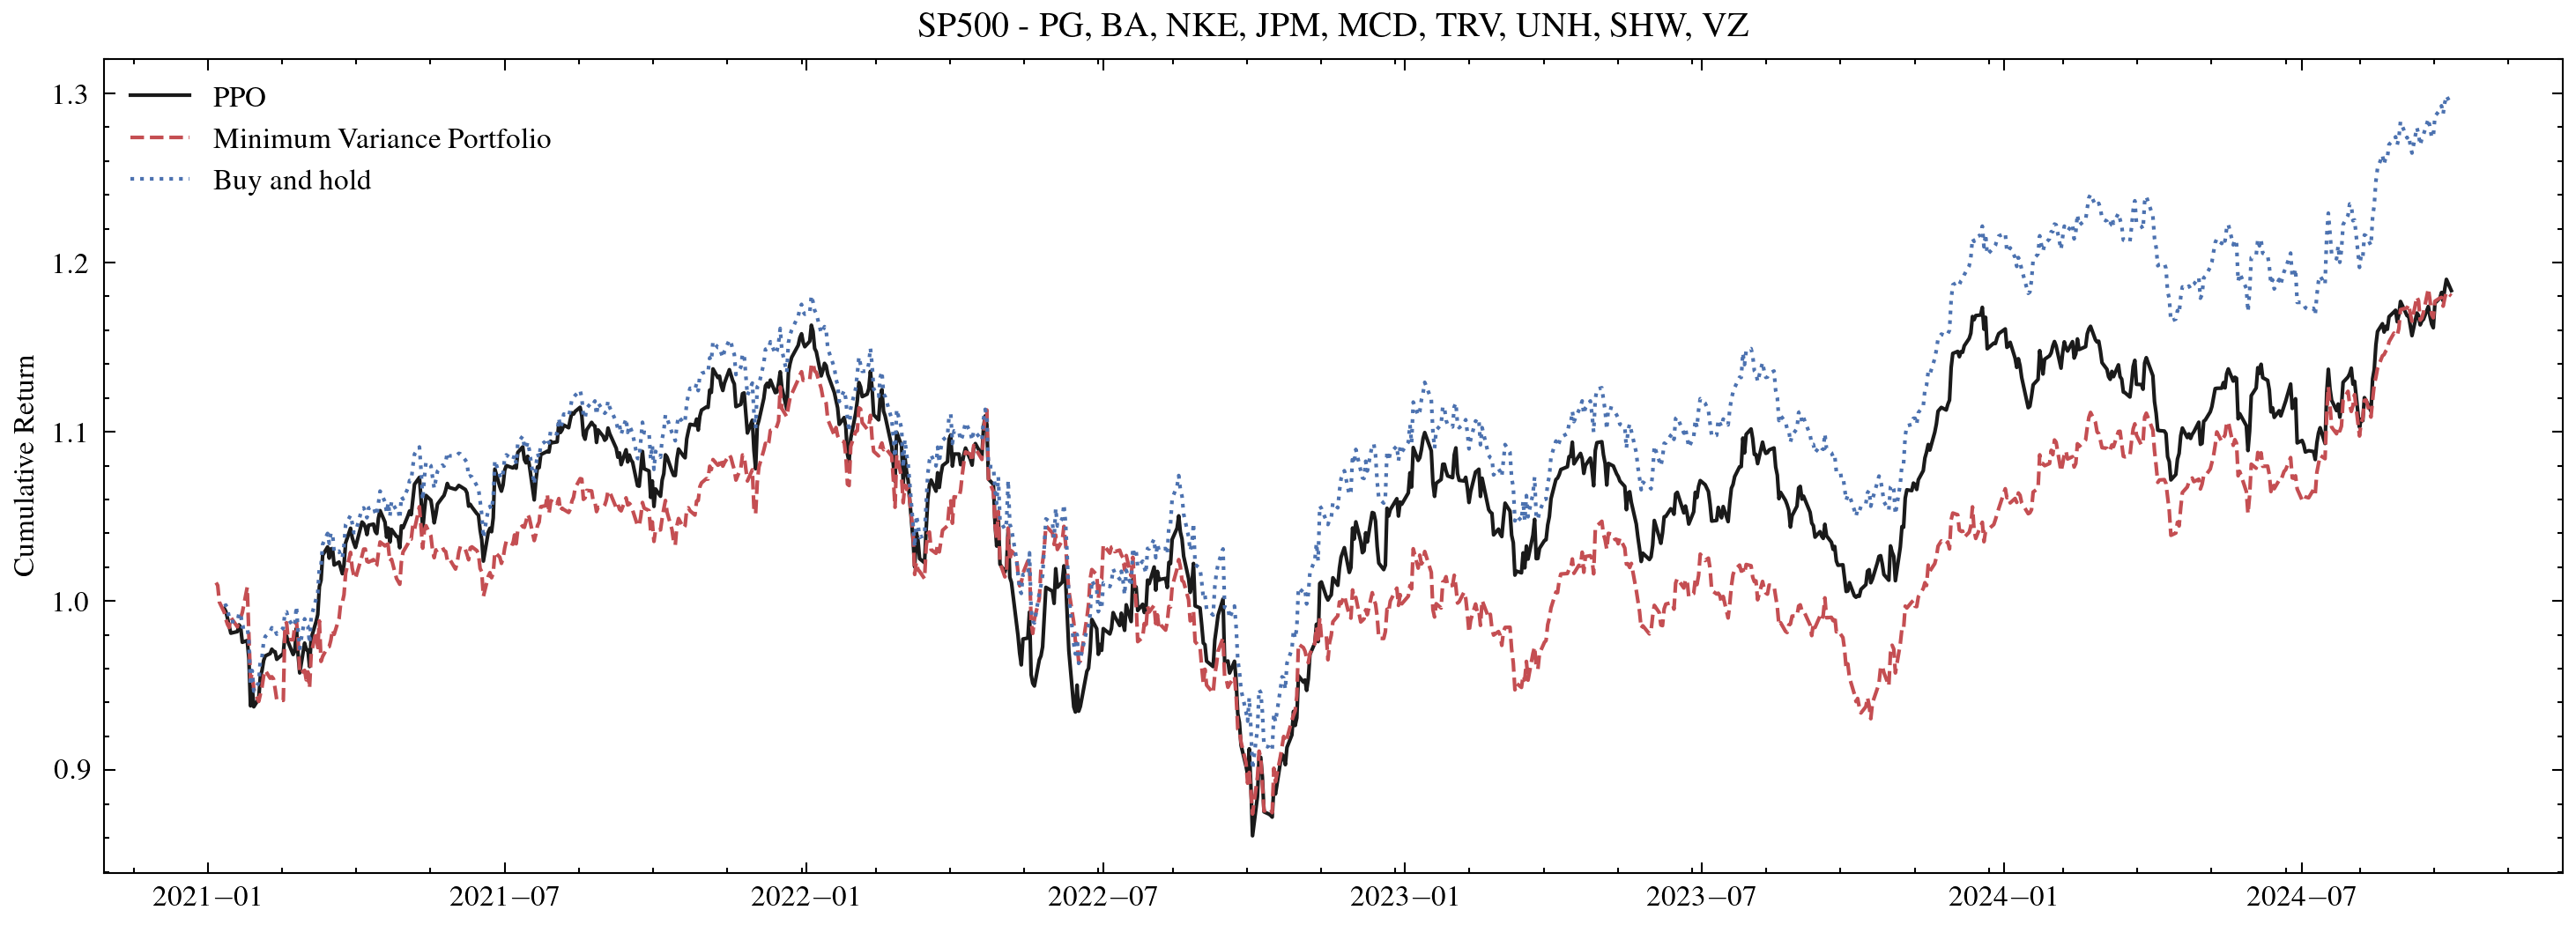

In [31]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
%matplotlib inline
plt.figure(figsize=(12,4),dpi=300)
plt.plot(test_result_sp500[0].get('date'),(test_result_sp500[0]['account'].pct_change() +1).cumprod(),label='PPO')
plt.plot(result_sp500['test'].date,(result_sp500['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
plt.legend()
plt.ylabel('Cumulative Return')
plt.title('SP500 - PG, BA, NKE, JPM, MCD, TRV, UNH, SHW, VZ')
plt.savefig('dow_comparison.png', dpi=500)
plt.show()